In [1]:
import random
import numpy as np

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.models import resnet50

from tqdm.notebook import tqdm, trange

# Фиксируем random seed для воспроизводимости результатов
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


OUTPUT_DIM = 10  # Количество классов
EPOCH_NUM = 4  # Сколько эпох будет обучать модель

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import cv2
import copy
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from typing import List, Tuple

In [3]:
basic_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

In [4]:
# Загрузим данные

train_dataset = FashionMNIST(
    root='./data/train',
    train=True,
    transform=basic_transform,
    download=True
)

test_dataset = FashionMNIST(
    root='./data/test',
    train=False,
    transform=test_transform,  # Для тестовых данные НЕ НАДО использовать никакие аугментации
    download=True
)

In [5]:
# Создадим DataLoader'ы (для того чтобы было проще итерироваться)

dataloaders = {
    'train': DataLoader(
        dataset=train_dataset,
        batch_size=128, 
        shuffle=True
    ),
    'val': DataLoader(
        dataset=test_dataset,
        batch_size=128, 
        shuffle=False
    )
}

In [6]:
# Создадим класс нашей модели

# Так как мы хотим использовать все фишки библиотеки Pytorch важно наследоваться от nn.Module
class FashionClassifier(nn.Module):
    def __init__(self, ouput_dim):
        super(FashionClassifier, self).__init__()  # "Регистрируем" создаваемый объект как нейросетевую модель
        self.model = resnet50(pretrained=True)  # Скачиваем пред-обученную основу для нашей модели
        
        # "Замораживаем" все веса для ускорения обучения (мы считаем что они уже хорошо обучены)
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Создаем "голову" которую мы и будем обучать
        self.fc1 = nn.Sequential(
            nn.Linear(1000, 64),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(64, ouput_dim)
        )
    
    def embed(self, x):
        return self.fc1(self.model(x))
    
    # Описываем как именно наша модель будет генерировать предсказания
    def forward(self, x):
        resnet_out = self.embed(x)
        return self.fc2(resnet_out)


In [7]:
model = FashionClassifier(OUTPUT_DIM)

In [8]:
# Создаем функцию ошибки (так как задача многоклассовой классификации, то используем кросс-энтропию)
# Более подробно об этом будет в курсе машинного обучения
loss_function = torch.nn.CrossEntropyLoss()

# Регистрируем для нашей модели способ изменения её весов
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)


In [9]:
loss_hist = {'train': [], 'val': []}
acc_hist = {'train': [], 'val': []}

# Важно! В данном примере точность используется для упрощения.
# Никогда не используйте её если у вас несбалансированная выборка
# Возьмите лучше F_score или ROC_AUC (об этом вам потом расскажут)

# Основной алгоритм обучения
for epoch in trange(EPOCH_NUM, desc='Whole pipeline'):
    
    for phase in ['train', 'val']:
        dataloader = dataloaders[phase]
        
        # Это условие необходимо так как у нас есть слой DropOut
        # И на валидации его принято фиксировать
        if phase == 'train':
            model.train() 
        elif phase == 'val':
            model.eval()
        
        running_loss = 0.
        running_acc = 0.
        
        # Проходимся по набору данных
        for (X_batch, y_batch) in tqdm(dataloader, desc=f'Epoch: {epoch + 1}. Phase: {phase}'):
            # Нормализуем наши данные
            X_batch = X_batch / 255
            X_batch = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X_batch)
            
            
            # Для корректного обучения перед каждым шагом необходимо сбрасывать прошлые ошибки
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)
                
                loss_value = loss_function(y_pred, y_batch)
                y_pred_class = y_pred.argmax(dim=1)
                
                # На обучении мы хотим учиться в зависимости от ошибки
                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()
                   
            # Аггрегируем ошибку и точность
            running_loss += loss_value.item()
            running_acc += (y_pred_class == y_batch.data).float().mean().data.cpu().numpy()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)
        
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ', end='')
        
        loss_hist[phase].append(epoch_loss)
        acc_hist[phase].append(epoch_acc)

Whole pipeline:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1. Phase: train:   0%|          | 0/469 [00:00<?, ?it/s]

train Loss: 1.8863 Acc: 0.3518 

Epoch: 1. Phase: val:   0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 29.7947 Acc: 0.0990 

Epoch: 2. Phase: train:   0%|          | 0/469 [00:00<?, ?it/s]

train Loss: 1.5682 Acc: 0.4509 

Epoch: 2. Phase: val:   0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 27.4725 Acc: 0.0907 

Epoch: 3. Phase: train:   0%|          | 0/469 [00:00<?, ?it/s]

train Loss: 1.4824 Acc: 0.4752 

Epoch: 3. Phase: val:   0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 23.1905 Acc: 0.0966 

Epoch: 4. Phase: train:   0%|          | 0/469 [00:00<?, ?it/s]

train Loss: 1.4327 Acc: 0.4904 

Epoch: 4. Phase: val:   0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 20.0486 Acc: 0.1080 

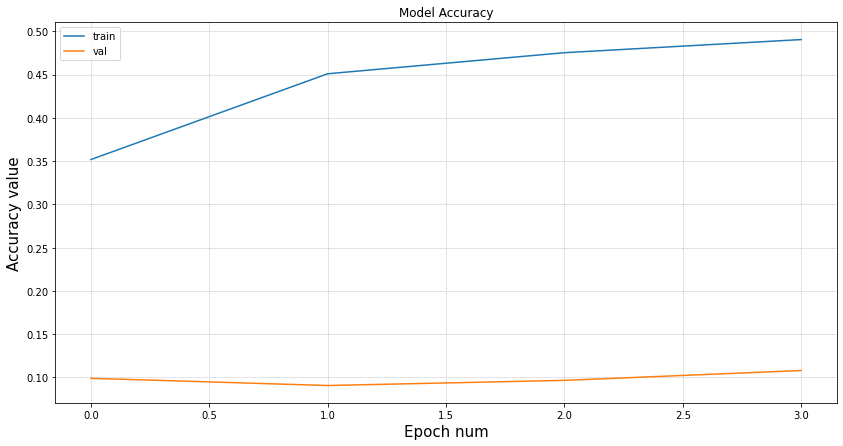

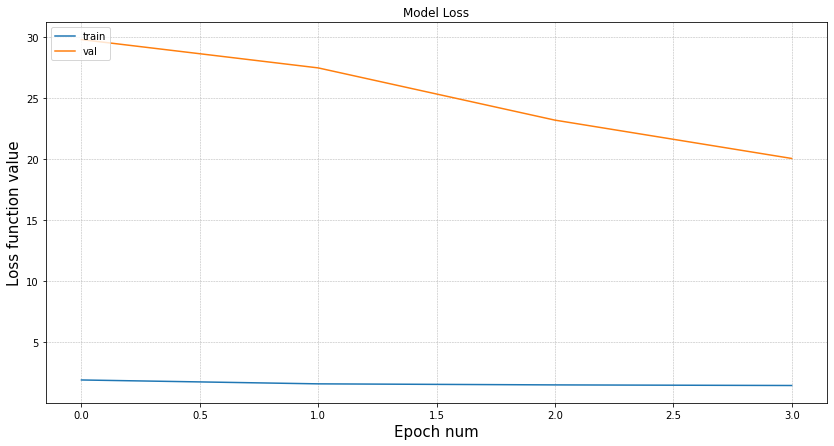

In [10]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

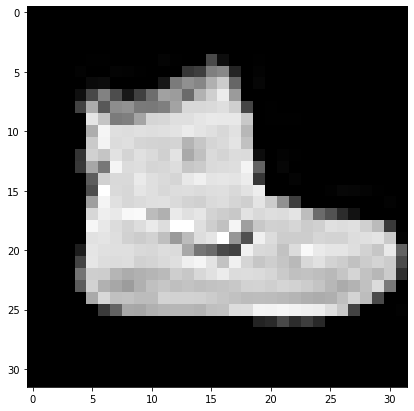

In [11]:
img = train_dataset[0][0].detach().numpy()

plt.imshow(np.transpose(img, (1,2,0)))

In [12]:
train_items = [train_dataset[i] for i in range(1000)]
xs, ys = zip(*train_items)

xs = torch.stack(xs)
xs = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(xs)
xs.size()

torch.Size([1000, 3, 32, 32])

In [13]:
embs = model.embed(xs)
embs.size()

torch.Size([1000, 64])

In [14]:
import umap 

points = umap.UMAP().fit_transform(embs.detach().numpy())
points.shape

(1000, 2)

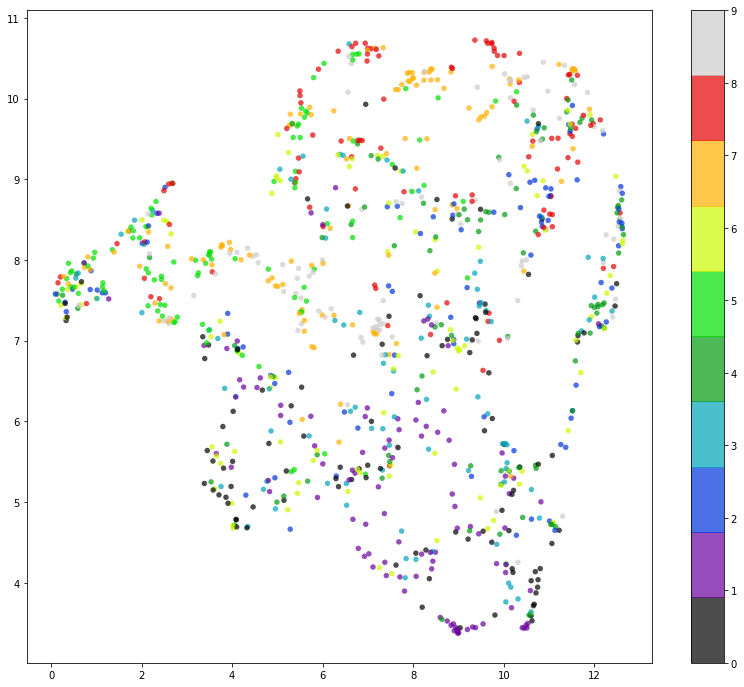

In [15]:
plt.figure(figsize=(14,12))
plt.scatter(points[:, 0], points[:, 1], c=ys, 
            edgecolor='none', alpha=0.7, s=30,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

In [16]:
import tensorflow as tf
import tensorboard as tb
from torch.utils.tensorboard import SummaryWriter
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

writer = SummaryWriter()

In [17]:
# log embeddings
writer.add_embedding(embs,
                     metadata=ys,
                     label_img=xs)
writer.close()

In [18]:
#!tensorboard --logdir runs --bind_all